توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

<div dir="rtl">

# تشخیص تغییرات با استفاده از شبکه های `CNN`
    
</div>

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



<div dir="rtl">

## دانلود دیتاست و dependency ها

در این قسمت ما دیتاست و کتابخانه های مورد نیاز را در صورت نیاز دانلود میکنیم.

</div>

In [1]:
## download data
# %%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.3/450.3 kB 17.3 MB/s eta 0:00:00


<div dir="rtl">

## import کردن کتابخانه های مورد نیاز
    
در این قسمت هر کتابخانه ای مورد نیاز ما است را import میکنیم.
    
</div>

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
# function 1
def displacement(img, shift):
    shift_x, shift_y = shift
    rows, cols, _ = img.shape
    img_displaced = cv2.warpAffine(
        img, np.float32([[1, 0, shift_x], [0, 1, shift_y]]),
        (cols, rows), borderMode=cv2.BORDER_REFLECT)
    return img_displaced

# function 2
def rotation(img, angle):
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img_rotated = cv2.warpAffine(
        img, M, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    return img_rotated

# function 3
def scaling(img, factor):
    img_scaled = cv2.resize(
        img, None, fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)
    return img_scaled

# function 4
def Brightness(img, alpha, beta):  ## for augmentation
    img_bright = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return img_bright

# function 5
def bluring(img, kernel):# for augmentation
    img_blurred = cv2.GaussianBlur(img, (kernel, kernel), 0)
    return img_blurred

# function 6
def gaussian_noise(img,std):#for augmentation
    h, w, c = img.shape
    gauss = np.random.normal(0, std, (h, w, c))
    img_noisy = np.clip(img + gauss, 0, 255).astype(np.uint8)
    return img_noisy

<div dir="rtl">

### تابع مورد استفاده برای ایجاد تغییر

این تابع در ادامه کد استفاده میشود تا که بر روی هر عکس، یک یا چند تغییر را به صورت تصادفی اعمال کند، ممکن است هم هیچ تغییری ایجاد نکند، و در نهایت عکس تغییر یافته و لیستی از تغییرات اعمال شده را به ما باز می گرداند.
    
</div>

In [4]:
def random_transform(img):
    transform_functions = [
        (lambda img, shift, angle, factor: displacement(img, shift)),
        (lambda img, shift, angle, factor: rotation(img, angle)),
        (lambda img, shift, angle, factor: scaling(img, factor)),
    ]

    w, h, c = img.shape
    shift_range = w / 2
    angle_range = 30
    scale_range = (0.5, 2)

    shift = np.random.randint(-shift_range, shift_range, size=2)
    angle = np.random.uniform(-angle_range, angle_range)
    factor = np.random.uniform(*scale_range)

    # list of applied transforms
    applied_transforms = [0] * len(transform_functions)

    # Apply the transformations
    for transform_func in np.random.choice(transform_functions, size=np.random.randint(0, len(transform_functions)+1), replace=False):
        img = transform_func(img, shift, angle, factor)
        applied_transforms[transform_functions.index(transform_func)] = 1

    return img, applied_transforms

<div dir="rtl">
    
### تابع استفاده شده برای augmentation
    
این تابع اینگونه است که به احتمال 40 درصد، تغییری در تصویر ایجاد نکرده، و به احتمال 60 درصد یکی از 3 تغییر 4 تا 6 را به صورت تصادفی انتخاب کرده و اعمال می کند، این تابع بعد تر نقش augment کردن داده ما را دارد.
    
</div>

In [8]:
def random_augment(img):
    transform_functions = [(lambda img, alpha, beta, kernel, std: img) for _ in range(5)]
    transform_functions[0:2] = [
        (lambda img, alpha, beta, kernel, std: Brightness(img, alpha, beta)),
        (lambda img, alpha, beta, kernel, std: bluring(img, kernel)),
        (lambda img, alpha, beta, kernel, std: gaussian_noise(img, std)),
    ]

    # Randomly choose parameters
    alpha = np.random.uniform(0.8, 1.2)  # Example range for alpha
    beta = np.random.uniform(-20, 20)     # Example range for beta
    kernel = np.random.choice([3, 5, 7])  # Example choices for kernel size
    std = np.random.uniform(0, 20)       # Example range for standard deviation

    transform_func = np.random.choice(transform_functions)
    img = transform_func(img, alpha, beta, kernel, std)

    return img

<div dir="rtl">
  
 ## ساخت و آماده سازی Dataset
    
 این قسمت از کد مربوط به تعریف کلاس `CustomDataset` است که یک زیرکلاس از `torch.utils.data.Dataset` می‌باشد. این کلاس برای بارگیری و پردازش داده ها مخصوص استفاده برای هدف تشخیص تغییرات ساخته شده است، به صورتی که در `__getitem__` به ما 2 عکس و تغییرات متناظر آنها را خروجی می دهد.

در کانستراکتور این کلاس، ویژگی های مهم زیر تعریف شده اند:

- `root_dir`: مسیر دایرکتوری اصلی که تصاویر در آن قرار دارند.
- `label_dir`: مسیر فایلی که حاوی اطلاعات برچسب‌ها و نام تصاویر می‌باشد. (می توانستیم از این استفاده نکنیم، همانطور که برای test استفاده نمیکنیم)
- `train`: یک بولین که نشان می‌دهد آیا در حال آموزش مدل هستیم یا تست.
- `transform`: تابع مولد تغییرات بین 2 تصویر، در اینجا تابع `random_transform` استفاده شده.
- `def_transform`: یک تابع تغییرات پیش‌فرض که در صورت وجود بر روی تصاویر اعمال می‌شود. (اعم از سایز کردن تصویر به سایز دلخواه، تبدیل به تانسور و...)
- `format`: فرمت تصاویر (مثلاً '.jpg').
- `ratio`: نسبتی از داده‌ها که برای استفاده انتخاب می‌شود (مقدار پیش‌فرض 1.0 به معنای استفاده از تمام داده‌هاست).
- `in_memory`: یک بولین که نشان می‌دهد آیا تصاویر به RAM بارگیری شوند یا خیر.
- `memory_ratio`: نسبتی از داده‌ها که در حافظه RAM بارگیری شده است.

متغیرهای مهم دیگر که در تابع کانستراکتور ایجاد می‌شوند عبارتند از:

- `self.data`: یک لیست از اسم تصاویر و که از آن فایل مشخص شده خوانده می‌شود.
- `self.loaded_data`: در صورتی که تصاویر به RAM بارگیری شوند، این متغیر داده های لوود شده را خواهد داشت..

توابع این کلاس شامل:

- `_load_data`: یک تابع خصوصی برای بارگیری داده‌ها به حافظه در صورت استفاده از این ویژگی.
- `__getitem__`: یک تابع که تصویرها و تغییرات متناظر را برمی‌گرداند، تابع اصلی ای که توسط `DataLoader` استفاده می شود، در صورت وجود در RAM از حافظه خروجی داده و در غیر این صورت، از دیسک IO کرده و خروجی میدهدک..
- `load_data`: یک تابع که تصاویر را از دیسک لوود کرده و تغییرات لازم را بر روی آن‌ها اعمال می‌کند.
    
</div>

In [10]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, label_dir, train, transform, def_transform=None, format='.jpg', ratio=1.0, in_memory=True, memory_ratio=1.0):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.def_transform = def_transform
        self.transform = transform
        self.format = format
        self.mode = '_test_' if not train else '_train_'
        
        with open(self.label_dir, 'r') as file:
            lines = file.readlines()
            
        self.data = [line.strip().split() for line in lines if self.mode in line]
        self.data = self.data[0:int(len(self.data) * ratio)]
        
        self.loaded_data = None
        self.memory_ratio = memory_ratio
        if in_memory:
            self.loaded_data = self._load_data()

    def _load_data(self):
        from tqdm import tqdm
        loaded_data = []
        print('Dataset size: ', len(self.data))
        
        sz = int(len(self.data) * self.memory_ratio)
        
        for idx in tqdm(range(sz), desc='loading data into memory...'):
            image, image2, transforms = self.load_data(idx)
            loaded_data.append((image, image2, transforms))
            
        return loaded_data

    def __getitem__(self, idx):
        if self.loaded_data is not None:
            if idx <= (len(self.loaded_data) - 1):
                return self.loaded_data[idx]
        return self.load_data(idx)
    
    def load_data(self, idx):
        img_name = self.data[idx][0]
        img_path = os.path.join(
            self.root_dir,
            img_name if self.format in img_name else img_name + self.format,
        )
        image = IM(img_path)
        
        image = random_augment(image) # data augmentation
        
        image2, transforms = self.transform(image)

        if self.def_transform:
            image = self.def_transform(image)
            image2 = self.def_transform(image2)

        transforms = np.array(transforms)

        return image, image2, transforms
    
    def __len__(self):
        return len(self.data)


<div dir="rtl">

## ساخت DataLoader و Dataset

در اینجا تصمیم گرفتیم که از 30 درصد کل داده های train استفاده کرده و آن را به طور کامل روی RAM بارگزاری کنیم.
برای داده test ولی تمامی اطلاعات را استفاده میکنیم و هربار لوود میکنیم زیرا سایز کوچکی دارد و نیاز به لوود زیاد آن نیست.
    
</div>

In [11]:
# Colab
base_path = './ADEChallengeData2016/images/'
label_path = './ADEChallengeData2016/sceneCategories.txt'
base_test = './release_test/'
label_test = './release_test/list.txt'
# Kaggle

target_size = (224, 224)
# target_size = (128, 128)
transform = transforms.Compose([
    transforms.ToTensor(),                            # Convert images to PyTorch tensors
    transforms.Resize(target_size, antialias=True),   # Resize images to the target size
    transforms.Normalize((0.5,), (0.5,)),             # Normalize pixel values to the range [-1, 1]
])

full_dataset = CustomDataset(
    root_dir=os.path.join(base_path, 'training'),
    label_dir=label_path,
    train=True,
    def_transform=transform,
    transform=random_transform,
    ratio=0.3, # adjust to see which part of dataset we want
    memory_ratio=1.0,
)

num_samples = len(full_dataset)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
dataset_train, dataset_val = random_split(full_dataset, [train_size, val_size])

import gc
del full_dataset
gc.collect()

dataset_test = CustomDataset(
    root_dir=os.path.join(base_test, 'testing'),
    label_dir=label_test,
    train=False,
    def_transform=transform,
    transform=random_transform,
    in_memory=False,
)

batch_size = 64
# batch_size = 1 # online
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)
test_loader= DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)

# Check the dataset sizes
print(f"Number of training examples: {len(dataset_train)}")
print(f"Number of validation examples: {len(dataset_val)}")
print(f"Number of test examples: {len(dataset_test)}")

Dataset size:  6063


loading data into memory...: 100%|██████████| 6063/6063 [01:42<00:00, 59.03it/s] 


Number of training examples: 4850
Number of validation examples: 1213
Number of test examples: 3352




## تجسم داده

کد داده‌های آموزش، اعتبارسنجی و آزمون را بارگیری می‌کند و تصاویر نمونه را از هر مجموعه نشان می‌دهد.

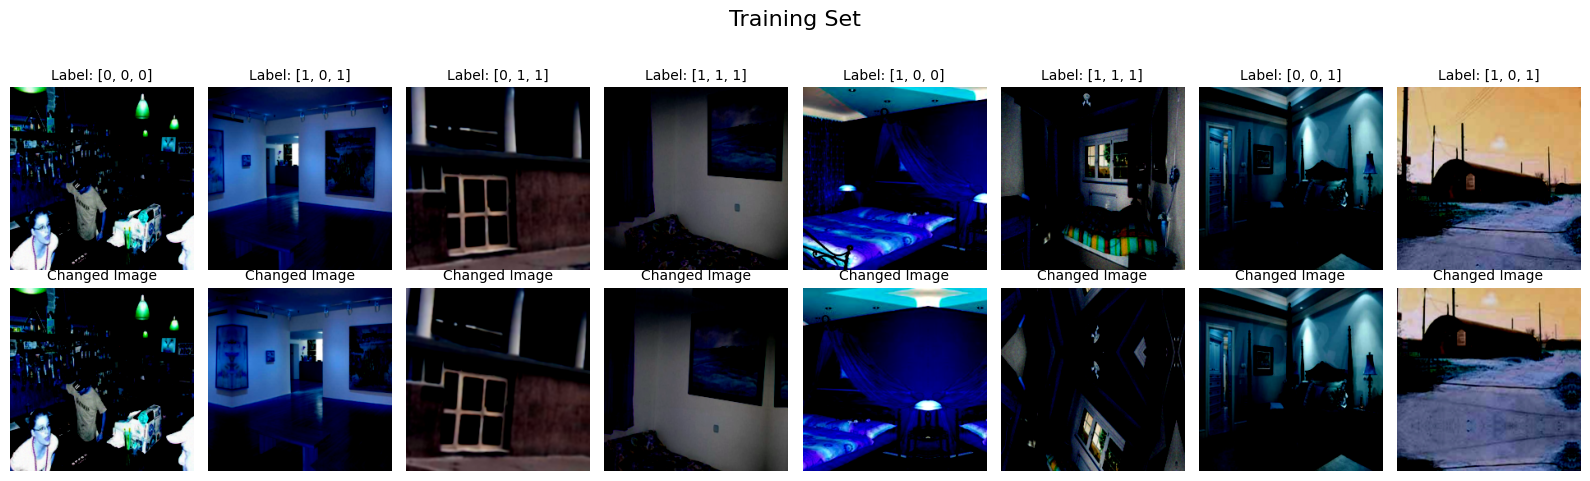

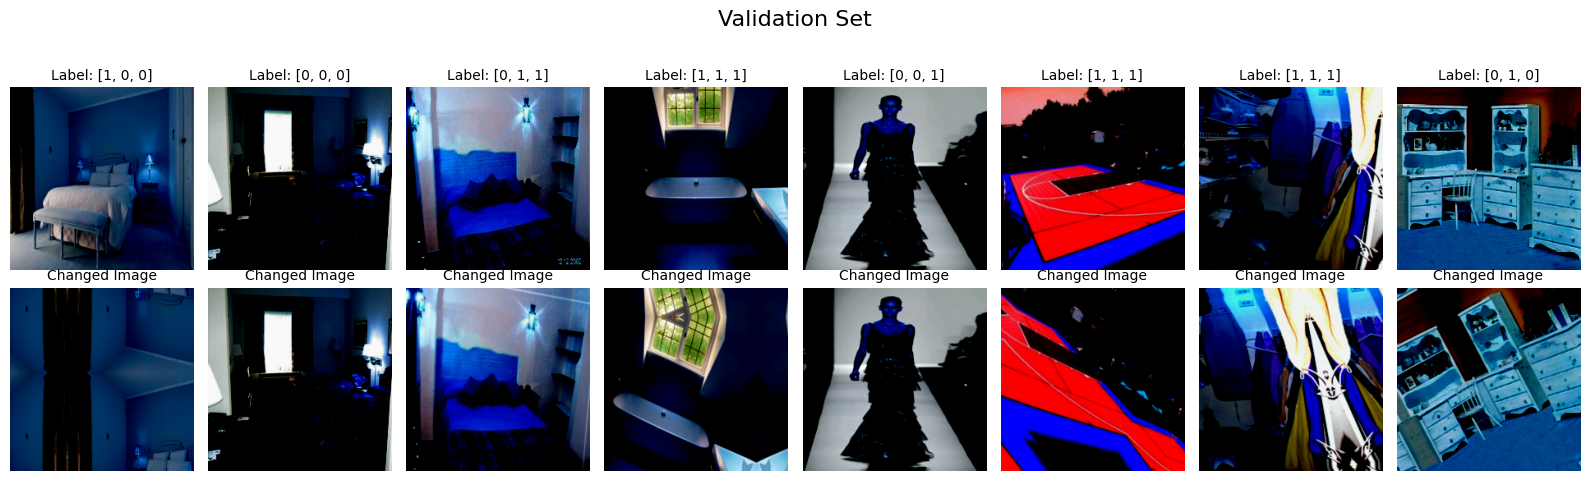

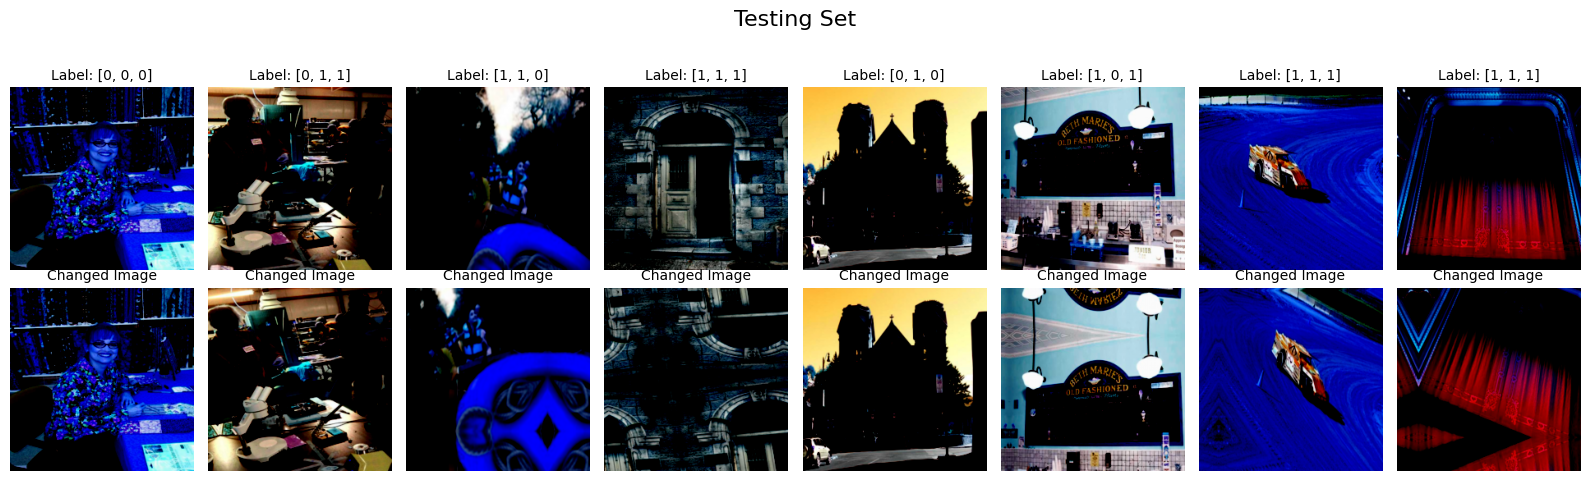

In [12]:
## To Do  : show 8 images from train_loader & 8 images from test_loader

# Assuming your DataLoader provides (images, labels)
for loader, title in zip([train_loader, val_loader, test_loader], ['Training Set', 'Validation Set', 'Testing Set']):
    for (data, data_changed, labels) in loader:
        # Plot the data
        plt.figure(figsize=(16, 5))
        plt.suptitle(title, fontsize=16)
        data = torch.clamp(data, 0, 1)
        data_changed = torch.clamp(data_changed, 0, 1)

        for i in range(8):
            plt.subplot(2, 8, i + 1)
            plt.imshow(data[i].permute(1, 2, 0))
            plt.title(f'Label: {labels[i, :].tolist()}', fontsize=10)
            plt.axis('off')

            plt.subplot(2, 8, i + 9)  # Second row for changed images
            plt.imshow(data_changed[i].permute(1, 2, 0))
            plt.title('Changed Image', fontsize=10)
            plt.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        break  # Break after the first batch

همانطور که واضح است 2 تصویر خروجی گرفته و لیبل آن تغییرات اعمال شده است.

## Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

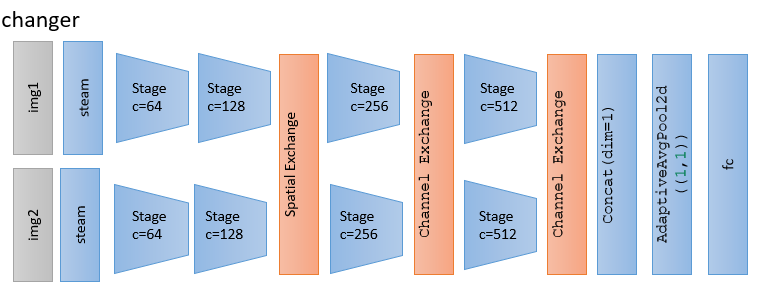

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


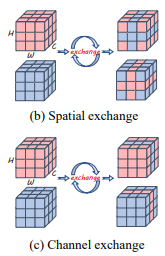

In [13]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

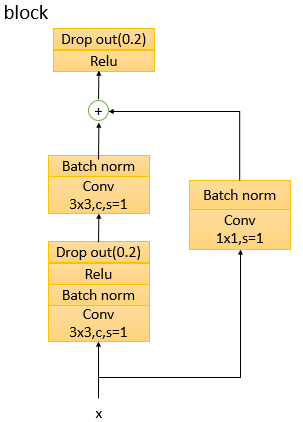

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





<div dir="rtl">

### پاسخ به سوال تئوری1

1. طبق اینکه skip connection با استفاده از bottleneck استفاده کرده ایم، منطقی است که سایز خروجی این بلوک با سایز ورودی آن برابر باشد، برای اینکه این خاصیت را داشته باشیم نیاز داریم که padding به صورت same اعمال شود، با توجه به اینکه سایز کرنل $3\times 3$ استفاده کرده ایم، برای لایه های کانولوشنی اصلی از `padding=1` استفاده کرده ایم.
تعداد کانال خروجی لایه bottleneck و لایه نهایی کانولوشنی در مسیر اصلی نیز از بیرون تنظیم میشود. `c` تعداد کانال میانی 
2. کانولوشن های 1در1 به لایه bottleneck معروف هستنند و هدف آنها تغییر تعداد کانال بدون تغییر اطلاعات spatial است، در اینجا میخواستیم skip-connection استفاده کنیم ولی تعداد کانال خروجی و ورودی متفاوت بوده اند پس از bottleneck استفاده کردیم که این مشکل رفع شود.
</div>

In [14]:
##To Do
class block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout_prob=0.2):
        super(block,self).__init__()
        # First block
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=kernel_size, stride=1, padding=1
        )
        self.BN1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout2d(p=dropout_prob)
        # Second block
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=kernel_size, stride=1, padding=1
        )
        self.BN2 = nn.BatchNorm2d(out_channels)
        # Residual block
        self.conv_res = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1, stride=1, padding=0
        )
        self.BN_res = nn.BatchNorm2d(out_channels)
        # Output block
        self.relu_out = nn.ReLU()
        self.dropout_out = nn.Dropout2d(p=dropout_prob)

    def forward(self, X):
        X_res = X.clone()
        # First block
        X = self.conv1(X)
        X = self.BN1(X)
        X = self.relu1(X)
        # Second block
        X = self.conv2(X)
        X = self.BN2(X)
        # Residual block
        res = self.conv_res(X_res)
        res = self.BN_res(res)
        X = X + res
        # Output block
        X = self.relu_out(X)
        X = self.dropout_out(X)
        return X

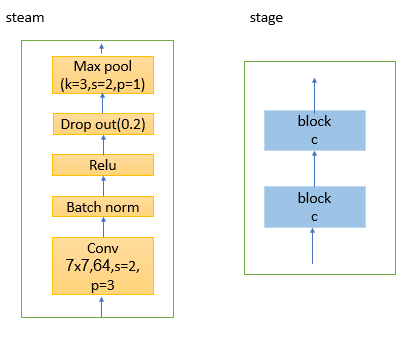

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

مدل زیر با توجه به تصاویر تکمیل شده است.

In [15]:
#To Do
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.bl = block
    self.SE = SpatialExchange()
    self.CE = ChannelExchange()

    self.steam_in_channel = 3
    self.dropout_prob = 0.2
    self.num_classes = 3

    self.steam=nn.Sequential(
        nn.Conv2d(
            in_channels=self.steam_in_channel, out_channels=64,
            kernel_size=7, stride=2, padding=3
        ),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(p=self.dropout_prob),
        nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1,
        )
    )

    self.stage1=self._make_stage(64, 64)
    self.stage2=self._make_stage(64, 128)
    self.stage3=self._make_stage(128, 256)
    self.stage4=self._make_stage(256, 512)

    self.pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc_in_features = 2 * 512
    self.fc = nn.Linear(
        in_features=self.fc_in_features,
        out_features=self.num_classes
    )

  def _make_stage(self, in_channels, out_channels):

    layers=[
        self.bl(
            in_channels=in_channels,
            out_channels=out_channels,
            ),
        self.bl(
            in_channels=out_channels,
            out_channels=out_channels,
            )
    ]

    return nn.Sequential(*layers)

  def forward(self,x1,x2):
    # Steaming
    x1 = self.steam(x1)
    x2 = self.steam(x2)
    # Stage 1, 2
    x1 = self.stage1(x1)
    x1 = self.stage2(x1)
    x2 = self.stage1(x2)
    x2 = self.stage2(x2)
    # Spatial Exchange
    x1, x2 = self.SE(x1, x2)
    # Stage 3
    x1 = self.stage3(x1)
    x2 = self.stage3(x2)
    # Channel Exchange
    x1, x2 = self.CE(x1, x2)
    # Stage 4
    x1 = self.stage4(x1)
    x2 = self.stage4(x2)
    # Channel Exchange
    x1, x2 = self.CE(x1, x2)
    # Concat
    Z = torch.cat((x1, x2), 1)
    # Output block
    Z = self.pool(Z)
    Z = torch.squeeze(Z, dim=(2, 3))
    out = self.fc(Z)

    return out

<div dir="rtl">

## ساخت مدل

در اینجا مدل نهایی را میسازیم، همچنین از `pytorch` استفاده میکنیم تا بیشینه استفاده از سیستم مورد دسترسی خود را ببریم، اعم از استفاده از `gpu` در صورتی که موجود است و حتی استفاده از معماری های موازی اگر موجود است.
    
در فرایند یادگیری ما از $2\times\text{T4 GPU}$ استفاده کردیم.

طبق اینکه درحال انجام multi-class classification هستیم. و در لایه خروجی مدل لز sigmoid استفاده نکردیم، 
حلقه آموزش با استفاده از BCEWithLogitsLoss و یک بهینه‌ساز Adam مدل را بهینه‌سازی می‌کند. زمان‌بندی نرخ یادگیری اعمال شده و پیشرفت آموزش با معیارهای loss و دقت نظارت می‌شود.
    
</div>

In [16]:
## To Do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = changer(block,SpatialExchange,ChannelExchange).to(device)

if torch.cuda.device_count() > 1:
    print("using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    model = model.to(device)

citeration = nn.BCEWithLogitsLoss() ## loss
learning_rate = 0.01 # initial LR
optimizer = optim.Adam(model.parameters(), lr=learning_rate) ## optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Using cuda device
using 2 GPUs!


## Train & validation


In [18]:
from tqdm import tqdm

Loss={'train':[], 'val':[]}
Acc={'total':[], 'class_1':[], 'class_2':[], 'class_3':[]}

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    Sum_loss_train = 0.0
    num_correct_train = 0
    num_correct_1 = 0
    num_correct_2 = 0 
    num_correct_3 = 0

    for (inputs, inputs_deformed, labels) in tqdm(train_loader, desc=f'epoch: {epoch+1}/{num_epochs}'):
        inputs, inputs_deformed, labels = inputs.to(device), inputs_deformed.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs, inputs_deformed)
        loss = citeration(outputs.to(torch.float32), labels.to(torch.float32))
        loss.backward()
        optimizer.step()

        Sum_loss_train += loss.item()

        predicted = outputs > 0
        corr = (predicted == labels)
        num_correct_train += corr.sum().item()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        Sum_loss_val = 0.0
        num_correct_val = 0

        for (inputs_val, inputs_deformed_val, labels_val) in tqdm(val_loader, desc=f'Validation - epoch: {epoch+1}/{num_epochs}'):
            inputs_val, inputs_deformed_val, labels_val = inputs_val.to(device), inputs_deformed_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val, inputs_deformed_val)
            loss_val = citeration(outputs_val.to(torch.float32), labels_val.to(torch.float32))

            Sum_loss_val += loss_val.item()

            predicted_val = outputs_val > 0
            corr = (predicted_val == labels_val)
            num_correct_val += corr.sum().item()
            
            num_correct_1 += corr[:, 0].sum().item()
            num_correct_2 += corr[:, 1].sum().item()
            num_correct_3 += corr[:, 2].sum().item()

    # Calculate average validation loss and accuracy
    Loss['train'].append(Sum_loss_train / len(train_loader))
    Loss['val'].append(Sum_loss_val/ len(val_loader))
    Acc['total'].append((num_correct_val)/(3 * len(val_loader.dataset)))
    Acc['class_1'].append((num_correct_1)/(len(val_loader.dataset)))
    Acc['class_2'].append((num_correct_2)/(len(val_loader.dataset)))
    Acc['class_3'].append((num_correct_3)/(len(val_loader.dataset)))
    
    print(
        f'loss_TRAIN ={Sum_loss_train:.3f}',
        f',acc_train={(num_correct_train)}/{3 * len(train_loader.dataset)}',
        f',\t loss_val= {Sum_loss_val:.3f}',
        f', acc_val={(num_correct_val)}/{3 * len(val_loader.dataset)}'
    )
    scheduler.step()
    
    # saving model
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': Sum_loss_val,
    }, 'checkpoint.pth')

Validation - epoch: 1/10: 100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


loss_TRAIN =54.650 ,acc_train=7800/14550 ,	 loss_val= 11.053 , acc_val=2564/3639


Validation - epoch: 2/10: 100%|██████████| 19/19 [00:13<00:00,  1.39it/s]


loss_TRAIN =41.803 ,acc_train=10510/14550 ,	 loss_val= 10.092 , acc_val=2668/3639


Validation - epoch: 3/10: 100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


loss_TRAIN =38.120 ,acc_train=10962/14550 ,	 loss_val= 9.067 , acc_val=2782/3639


Validation - epoch: 4/10: 100%|██████████| 19/19 [00:13<00:00,  1.39it/s]


loss_TRAIN =35.907 ,acc_train=11262/14550 ,	 loss_val= 8.587 , acc_val=2815/3639


Validation - epoch: 5/10: 100%|██████████| 19/19 [00:13<00:00,  1.39it/s]


loss_TRAIN =35.049 ,acc_train=11353/14550 ,	 loss_val= 8.639 , acc_val=2820/3639


Validation - epoch: 6/10: 100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


loss_TRAIN =33.834 ,acc_train=11484/14550 ,	 loss_val= 8.315 , acc_val=2859/3639


Validation - epoch: 7/10: 100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


loss_TRAIN =33.622 ,acc_train=11508/14550 ,	 loss_val= 8.253 , acc_val=2871/3639


Validation - epoch: 8/10: 100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


loss_TRAIN =33.463 ,acc_train=11539/14550 ,	 loss_val= 8.177 , acc_val=2870/3639


Validation - epoch: 9/10: 100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


loss_TRAIN =33.168 ,acc_train=11565/14550 ,	 loss_val= 8.145 , acc_val=2878/3639


Validation - epoch: 10/10: 100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


loss_TRAIN =32.951 ,acc_train=11552/14550 ,	 loss_val= 8.210 , acc_val=2876/3639


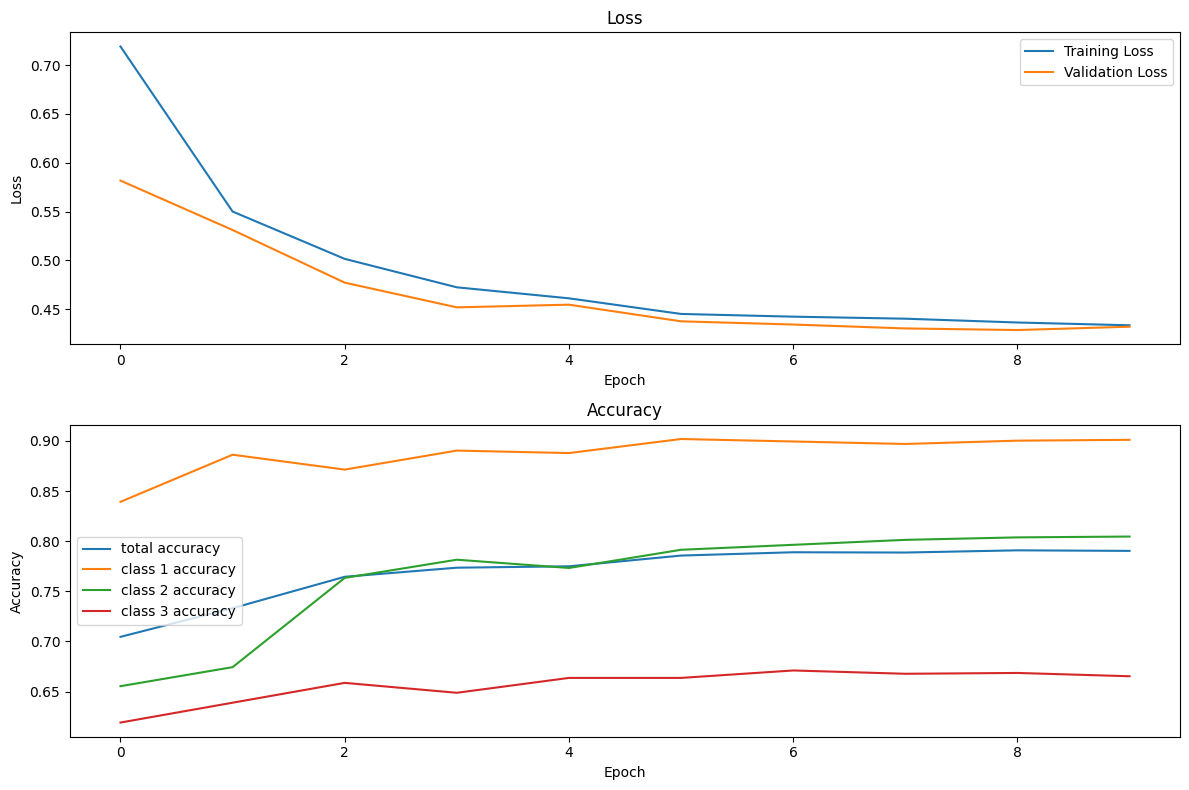

In [19]:
# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(Loss['train'], label='Training Loss')
ax1.plot(Loss['val'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(Acc['total'], label='total accuracy')
ax2.plot(Acc['class_1'], label='class 1 accuracy')
ax2.plot(Acc['class_2'], label='class 2 accuracy')
ax2.plot(Acc['class_3'], label='class 3 accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

همانطور که معلوم است، loss به صورت نزولی بوده، و دقت مدل نیز در تمامی کلاس ها به صورت افزایشی است پس یادگیری خوبی درحال انجام بوده است.

### ذخیره مدل

In [22]:
# saving model
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': Sum_loss_val,
}, 'checkpoint_Q3.pth')

In [23]:
from IPython.display import FileLink
FileLink(r'checkpoint_Q3.pth')

/kaggle/working/checkpoint.pth

# Test


حال داده را با استفاده از داده های تست، ارزیابی میکنیم.

In [36]:
checkpoint = torch.load('checkpoint_Q3.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## To Do test
# Testing loop
accuracy_test = 0
Sum_loss_test = 0.0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    total_correct = {'correct':0, 'items':0}
    one_correct = {'correct':0, 'items':0}
    two_correct = {'correct':0, 'items':0}
    three_correct = {'correct':0, 'items':0}
    num_correct_1 = 0
    num_correct_2 = 0 
    num_correct_3 = 0
    for (inputs, inputs_deformed, labels) in tqdm(test_loader, desc=f'Testing'):
        inputs, inputs_deformed, labels = inputs.to(device), inputs_deformed.to(device), labels.to(device)

        outputs = model(inputs, inputs_deformed)
        loss_test = citeration(outputs.to(torch.float32), labels.to(torch.float32))
        
        Sum_loss_test += loss_test.item()

        predicted_test = outputs > 0
        correct = (predicted_test == labels)
        
        num_correct_1 += corr[:, 0].sum().item()
        num_correct_2 += corr[:, 1].sum().item()
        num_correct_3 += corr[:, 2].sum().item()

        
        one_idx = (labels.sum(dim=1) == 1).nonzero()
        two_idx = (labels.sum(dim=1) == 2).nonzero()
        three_idx = (labels.sum(dim=1) == 3).nonzero()
        
        one_corr = correct[one_idx]
        two_corr = correct[two_idx]
        three_corr = correct[three_idx]
        
        total_correct['correct'] += correct.sum().item()
        total_correct['items'] += len(correct)
        one_correct['correct'] += one_corr.sum().item()
        one_correct['items'] += len(one_corr)
        two_correct['correct'] += two_corr.sum().item()
        two_correct['items'] += len(two_corr)
        three_correct['correct'] += three_corr.sum().item()
        three_correct['items'] += len(three_corr)
        
    accuracy_test = total_correct['correct'] / (3 * total_correct['items'])
    accuracy_one = one_correct['correct'] / (3 * one_correct['items'])
    accuracy_two = two_correct['correct'] / (3 * two_correct['items'])
    accuracy_three = three_correct['correct'] / (3 * three_correct['items'])

print(f' loss_test= {Sum_loss_test:.3f}, acc_test={(accuracy_test) * 100:.2f}%\n', 
     f'acc_test_one={(accuracy_one) * 100:.2f}%',
     f', acc_test_two={(accuracy_two) * 100:.2f}%',
     f', acc_test_three={(accuracy_three) * 100:.2f}%\n',
     f'class one accuracy={ ((num_correct_1)/(len(test_loader.dataset))) * 100:.2f}%',
     f', class two accuracy={ ((num_correct_2)/(len(test_loader.dataset))) * 100:.2f}%',
     f', class three accuracy={((num_correct_3)/(len(test_loader.dataset))) * 100:.2f}%')

Testing: 100%|██████████| 53/53 [01:00<00:00,  1.13s/it]

 loss_test= 22.599, acc_test=80.01%
 acc_test_one=52.51% , acc_test_two=69.07% , acc_test_three=98.11%
 class one accuracy=90.13% , class two accuracy=74.31% , class three accuracy=61.66%


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

<div dir="rtl">

## پاسخ به سوال تئوری

همانطور که پیداست، 2 چیز را میبینیم.

1. مدل ما تغییر اول یعنی displacement را با دقت حدود `90.13%` تشخیص میدهد، که مورد انتظار است زیرا مدل های کانولوشنی به این تغییر مقاوم بوده در نتیجه در Spatial exchange به خوبی واضح میشود، بعدی داده ما Rotation را با دقت `74.31%` تشخیص میدهد، که توسط Channel Exchange به نحوی مدیریت میشود، کمترین دقت را مدل ما در تشخیص Scaling داشته زیرا خروجی را به کل تغییر میدهد و ما نیز راهی تر کانال های خود برای استخراج ویژگی های مربوط به این نداشتیم که کمترین دقت با حدود `61.66%` را میبینیم.
2. در مورد تعداد تغییر، به نظر مدل ما بیشتر مشکل False Positve را دچار شده، که حال accuracy های خوبی میدهد، ولی برای مثال زمانی که فقط یک تغییر داریم، معمولا بیش از 1 تغییر را پیش بینی میکند که دقت آن را کم می کند، ولی 2 تغییر را بهتر و 3 تغییر را با بیشترین دقت تشخیص میدهد.
    
</div>